Purpose of this notebook:
1. Explore the data
2. Understand customer base
3. Explore factors that could affect the price column

#### Imports

In [5]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
import pingouin as pg


leave a messsage

#### Exploration

In [598]:
PATH = "./data/"

In [599]:
# reading files
customer_data = pd.read_csv(PATH + 'user_demographics_v1.csv', parse_dates=['reg_date'])
app_purchases = pd.read_csv(PATH + 'purchase_data_v1.csv',parse_dates=['date'])

In [600]:
# exploring the customer data
print(customer_data.head())
print(customer_data.columns)
print(customer_data.shape)
print("\n", customer_data.describe())

          uid                  reg_date device gender country  age
0  54030035.0 2017-06-29 00:00:00+00:00    and      M     USA   19
1  72574201.0 2018-03-05 00:00:00+00:00    iOS      F     TUR   22
2  64187558.0 2016-02-07 00:00:00+00:00    iOS      M     USA   16
3  92513925.0 2017-05-25 00:00:00+00:00    and      M     BRA   41
4  99231338.0 2017-03-26 00:00:00+00:00    iOS      M     FRA   59
Index(['uid', 'reg_date', 'device', 'gender', 'country', 'age'], dtype='object')
(10000, 6)

                 uid           age
count  1.000000e+04  10000.000000
mean   5.580304e+07     24.399200
std    2.562174e+07      9.772512
min    1.111609e+07     15.000000
25%    3.392627e+07     17.000000
50%    5.627628e+07     21.000000
75%    7.786440e+07     28.000000
max    9.999648e+07     84.000000


In [601]:
# exploring the app_purchases data
print(app_purchases.head())
print(app_purchases.columns)
print(app_purchases.shape)
print("\n", app_purchases.describe())

        date       uid            sku  price
0 2017-07-10  41195147  sku_three_499    499
1 2017-07-15  41195147  sku_three_499    499
2 2017-11-12  41195147   sku_four_599    599
3 2017-09-26  91591874    sku_two_299    299
4 2017-12-01  91591874   sku_four_599    599
Index(['date', 'uid', 'sku', 'price'], dtype='object')
(9006, 4)

                 uid        price
count  9.006000e+03  9006.000000
mean   5.719633e+07   406.772596
std    2.652288e+07   187.918230
min    1.115855e+07    99.000000
25%    3.421581e+07   299.000000
50%    5.790297e+07   299.000000
75%    8.172713e+07   499.000000
max    9.997504e+07   899.000000


In [602]:
# since both tables have a common key, 'uid', I'll merge on that column 
uid_combined_data = app_purchases.merge(customer_data, on='uid', how='inner')
uid_combined_data.head()

,date,uid,sku,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,sku_three_499,499,2017-06-26 00:00:00+00:00,and,M,BRA,17
1,2017-07-15,41195147,sku_three_499,499,2017-06-26 00:00:00+00:00,and,M,BRA,17
2,2017-11-12,41195147,sku_four_599,599,2017-06-26 00:00:00+00:00,and,M,BRA,17
3,2017-09-26,91591874,sku_two_299,299,2017-01-05 00:00:00+00:00,and,M,TUR,17
4,2017-12-01,91591874,sku_four_599,599,2017-01-05 00:00:00+00:00,and,M,TUR,17


In [603]:
uid_combined_data.shape

(9006, 9)

#### Exploring different statistics 
<ol> <li>price is in cents</li></ol>

In [604]:
uid_combined_data.describe()

,uid,price,age
count,9.006000e+03,9006.000000,9006.000000
mean,5.719633e+07,406.772596,23.922274
std,2.652288e+07,187.918230,9.044646
min,1.115855e+07,99.000000,15.000000
25%,3.421581e+07,299.000000,17.000000
50%,5.790297e+07,299.000000,21.000000
75%,8.172713e+07,499.000000,28.000000
max,9.997504e+07,899.000000,75.000000


In [605]:
# checking for missing values 
uid_combined_data.isnull().sum()

date        0
uid         0
sku         0
price       0
reg_date    0
device      0
gender      0
country     0
age         0
dtype: int64

### Exploring Price


In [606]:
# exploring the price column , price is in cents 
purchase_price_summary = uid_combined_data.price.agg(['mean', 'median', 'std', 'min', 'max'])
purchase_price_summary

mean      406.772596
median    299.000000
std       187.918230
min        99.000000
max       899.000000
Name: price, dtype: float64

In [607]:
# coefficient of variation = checking if its within a acceptable range < 0.5
cv = purchase_price_summary['std'] / purchase_price_summary['mean'] * 100
cv

46.197367340286554

<AxesSubplot:>

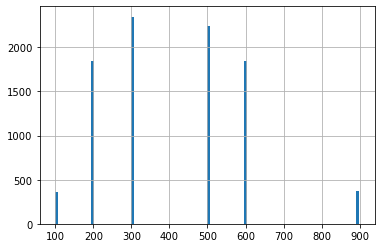

In [608]:
# now i'll look at the distribution of the price column
uid_combined_data.price.hist(bins=100)

<AxesSubplot:>

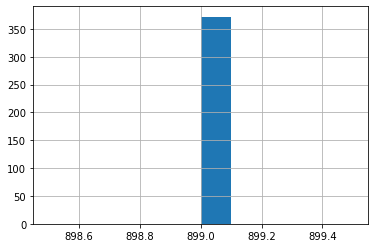

In [609]:
# checking if the $1 and $9 are outliers
q1 = uid_combined_data.price.quantile(0.25)
q3 = uid_combined_data.price.quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

price_outliers = uid_combined_data[(uid_combined_data['price']< lower_bound) | (uid_combined_data['price']>upper_bound)]
price_outliers.price.hist()

<b> Observation </b>
<ul>
<li> The average price is $4 </li>
<li> The highest price frequencies is $3 and $5 </li>
<li> The lowest price frequencies is $1 and $9 </li>
<li> $9 is an outlier, this suggests that its an extreme subscription offer in the data </li>




### Exploring Price & Age


In [610]:
# exploring the price & age columns
purchase_summary = uid_combined_data.agg({ 'age': ['mean', 'median', 'std', 'min', 'max']})
purchase_summary

,age
mean,23.922274
median,21.000000
std,9.044646
min,15.000000
max,75.000000


In [611]:
#  looking at each age group and its corresponding generated mean price
purchase_age = uid_combined_data.groupby('age').agg({'price': ['mean', 'median', 'std', 'min', 'max']})
purchase_age.head(10).sort_values(by=('price', 'mean'), ascending=False)

price                            
           mean median         std min  max
age                                        
15   415.405434  499.0  195.590605  99  899
17   414.138889  499.0  185.290007  99  899
21   409.062893  299.0  193.332659  99  899
16   406.593458  299.0  189.368426  99  899
23   406.455013  499.0  186.035556  99  899
18   405.049149  299.0  179.754898  99  899
19   404.821918  299.0  189.339402  99  899
20   404.613306  299.0  195.867962  99  899
24   399.923077  299.0  191.241260  99  899
22   398.025341  299.0  185.349715  99  899

<AxesSubplot:>

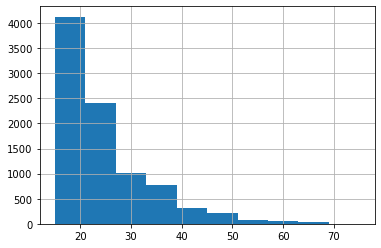

In [612]:
# age distribution
uid_combined_data.age.hist()

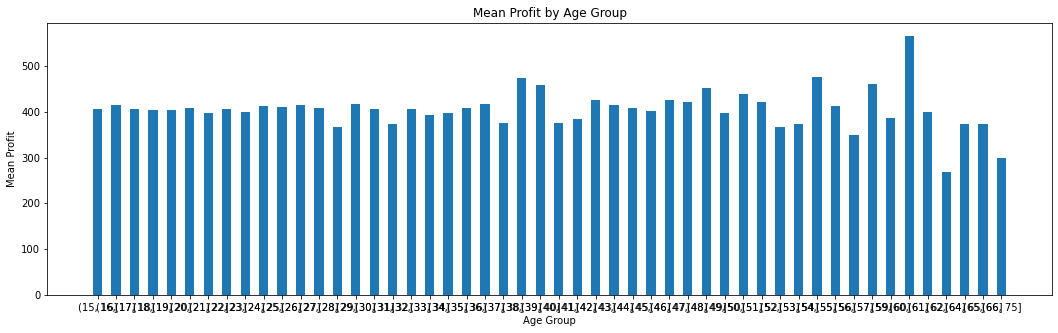

In [613]:
# zooming in on the age distribution and looking at the correlation with price
unique_ages = uid_combined_data.age.sort_values().unique()

uid_combined_data['age_group'] = pd.cut(uid_combined_data.age, bins= unique_ages)

profit_by_age_group = uid_combined_data.groupby('age_group')['price'].mean()

fig = plt.figure(figsize=(18, 5))
plt.bar(profit_by_age_group.index.astype(str), profit_by_age_group.values, width=0.5)
plt.xlabel('Age Group')
plt.ylabel('Mean Profit')
plt.title('Mean Profit by Age Group')
plt.show()


Potential age outliers: AxesSubplot(0.125,0.125;0.775x0.755)


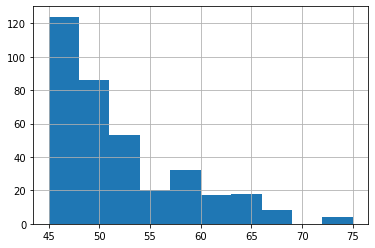

In [614]:
# due to spikes at ages 39 and 61 in price, I'll check for outliers 
q1_age = uid_combined_data.age.quantile(0.25)
q3_age = uid_combined_data.age.quantile(0.75)
iqr_age = q3_age - q1_age


lower_bound_age = q1_age - 1.5 * iqr_age
upper_bound_age = q3_age + 1.5 * iqr_age


age_outliers = uid_combined_data[(uid_combined_data['age']< lower_bound_age) | (uid_combined_data['age']> upper_bound_age)]

print('Potential age outliers:', age_outliers.age.hist())

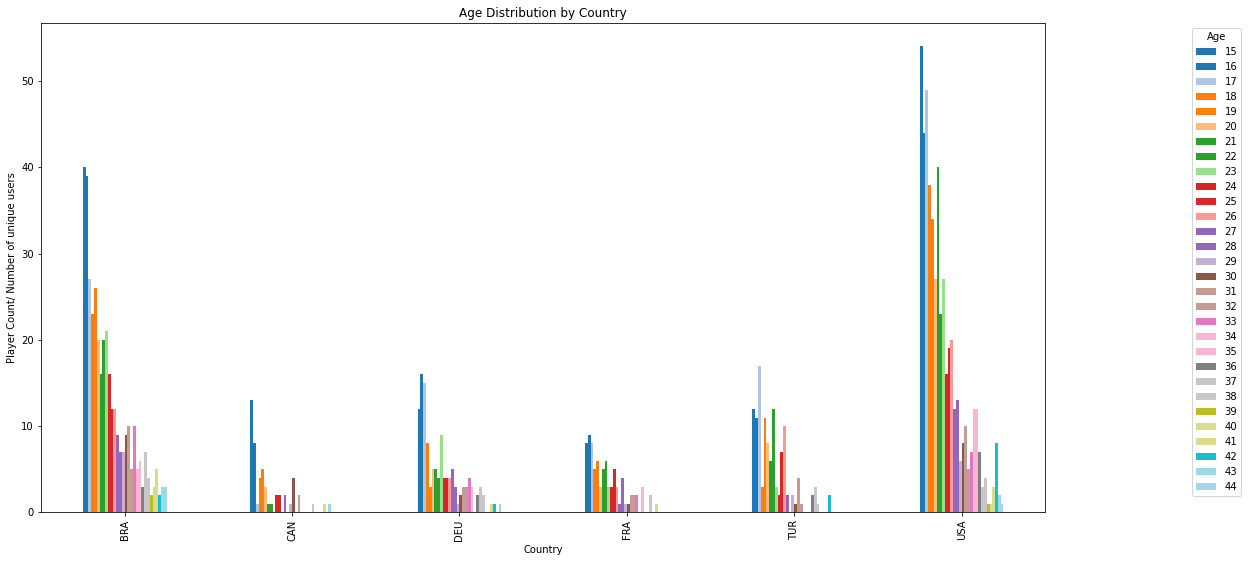

In [615]:
# looking at age distribution in each country 
filtered_ages_under_45 = uid_combined_data[uid_combined_data['age'] < 45]

# unique users per country
age_counts_per_country = filtered_ages_under_45.groupby(['country', 'age'])['uid'].nunique().reset_index(name='count')

fig, ax = plt.subplots(figsize=(18, 9))
cmap=plt.get_cmap('tab20')
age_counts_per_country.pivot(index= 'country', columns='age', values='count').plot(kind = 'bar', ax=ax,cmap=cmap)

ax.set_xlabel('Country')
ax.set_ylabel('Player Count/ Number of unique users')
ax.set_title ('Age Distribution by Country')
ax.legend(title='Age', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

<b> Observation </b>
<ul>
<li> The average user's age is 24 years old, and as young as 15 years old  </li>
<li> Users aged 15 generate the highest income </li>
<li> Users between the ages of 15 and 24 generate the most amount of income compared to other ages, and account for the highest distribution of users </li>
<li> Users from ages 45 onwards are considered outliers </li>
<li> In all the countries the app operates in, the most amount of users are within the 15 - 24 year old range </li>
 



### Exploring Price & Gender

In [616]:
# how many females to males 
gender_ratio = uid_combined_data.groupby(['gender']).uid.nunique()
gender_ratio

gender
F    712
M    610
Name: uid, dtype: int64

In [617]:
# exploring price and gender 
purchase_gender = uid_combined_data.groupby('gender').agg({'price': ['mean', 'median', 'std', 'min', 'max', 'sum']})
purchase_gender


price                                     
              mean median         std min  max      sum
gender                                                 
F       402.276978  299.0  180.615135  99  899  1927309
M       411.882562  499.0  195.785251  99  899  1736085

In [618]:
# because the mean doesn't align with the sum, i'll check for a significant difference between the mean price generated by males and females, 
male_data = uid_combined_data[uid_combined_data['gender']=='M']['price']
female_data = uid_combined_data[uid_combined_data['gender']=='F']['price']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_ind(male_data, female_data)

# Check if the p-value is significant (e.g. less than 0.05)
if p_value < 0.05:
    print('There is a significant difference between the mean price generated by males and females.')
else:
    print('There is not a significant difference between the mean price generated by males and females.')



There is a significant difference between the mean price generated by males and females.


In [619]:
# since there is a significance between the mean price generated both genders, i'll explore whether there is a relationship between gender and price

# Create dummy variables for gender
uid_combined_data["is_female"] = pd.get_dummies(uid_combined_data["gender"])["F"]

# Fit a linear regression model
X = sm.add_constant(uid_combined_data[["is_female"]])
y = uid_combined_data["price"]
model = sm.OLS(y, X).fit()

# Print the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.862
Date:                Fri, 17 Mar 2023   Prob (F-statistic):             0.0155
Time:                        15:53:49   Log-Likelihood:                -59931.
No. Observations:                9006   AIC:                         1.199e+05
Df Residuals:                    9004   BIC:                         1.199e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        411.8826      2.894    142.338      0.0

In [620]:
# Fit a linear regression model
uid_combined_data["is_male"] = pd.get_dummies(uid_combined_data["gender"])["M"]
X = sm.add_constant(uid_combined_data[["is_male"]])
y = uid_combined_data["price"]
model = sm.OLS(y, X).fit()

# Print the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.862
Date:                Fri, 17 Mar 2023   Prob (F-statistic):             0.0155
Time:                        15:53:49   Log-Likelihood:                -59931.
No. Observations:                9006   AIC:                         1.199e+05
Df Residuals:                    9004   BIC:                         1.199e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        402.2770      2.714    148.213      0.0

It seems that gender does play a part in how much revenue is generated. Males are more likely to pay, an average of 9.6056 more than females. 

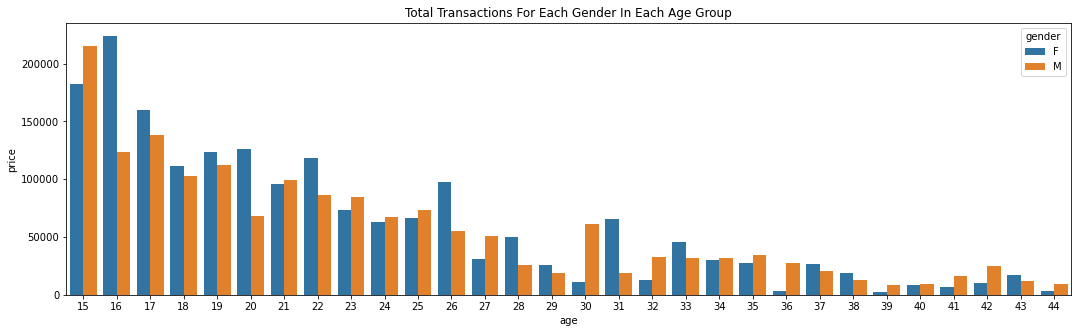

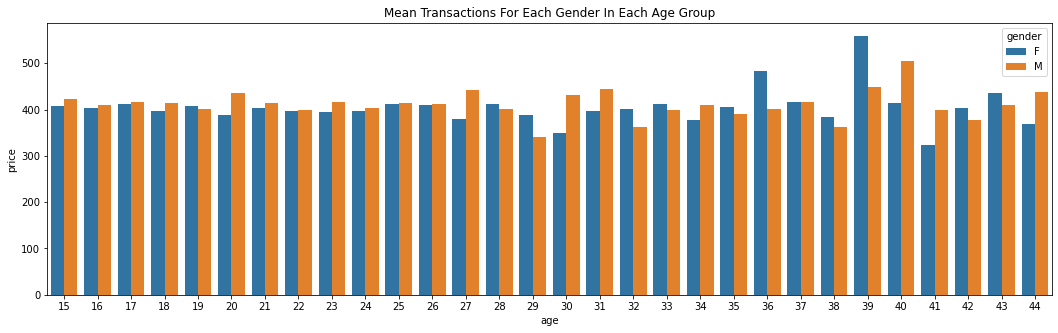

In [621]:
# is it a specific gender within the different age groups that is more likely to pay more for the subscription?

filtered_ages = uid_combined_data[uid_combined_data['age'] < 45]

purchase_age_group_sum = filtered_ages.groupby(['age', 'gender']).agg({'price': 'sum'})
purchase_age_group_mean = filtered_ages.groupby(['age', 'gender']).agg({'price': 'mean'})

purchase_age_group_sum = purchase_age_group_sum.reset_index()
purchase_age_group_mean = purchase_age_group_mean.reset_index()

# plot 
plt.figure(figsize=(18, 5))
p = sns.barplot(x='age', y='price', hue='gender', data=purchase_age_group_sum)
plt.title("Total Transactions For Each Gender In Each Age Group")
plt.show()

plt.figure(figsize=(18, 5))
p = sns.barplot(x='age', y='price', hue='gender', data=purchase_age_group_mean)
plt.title("Mean Transactions For Each Gender In Each Age Group")
plt.show()

In [622]:
male_age_fileted_total_purchase = purchase_age_group_sum[purchase_age_group_sum['gender']=='M'].price.sum()
female_age_fileted_total_purchase = purchase_age_group_sum[purchase_age_group_sum['gender']=='F'].price.sum()

male_age_fileted_mean_purchase = purchase_age_group_sum[purchase_age_group_sum['gender']=='M'].price.mean()
female_age_fileted_mean_purchase = purchase_age_group_sum[purchase_age_group_sum['gender']=='F'].price.mean()

if male_age_fileted_total_purchase >female_age_fileted_total_purchase:
    print("Males within the typical user age range generated more revenue in total  = {}".format(male_age_fileted_total_purchase))
else:
    print("Females within the typical user age range generated more revenue in total =  {}".format(female_age_fileted_total_purchase))

if male_age_fileted_mean_purchase >female_age_fileted_mean_purchase:
    print("Males within the typical user age range generated more revenue on average = {}".format(male_age_fileted_mean_purchase))
else:
    print("Females within the typical user age range generated more revenue on average  = {}".format(female_age_fileted_mean_purchase))


Females within the typical user age range generated more revenue in total =  1840122
Females within the typical user age range generated more revenue on average  = 61337.4


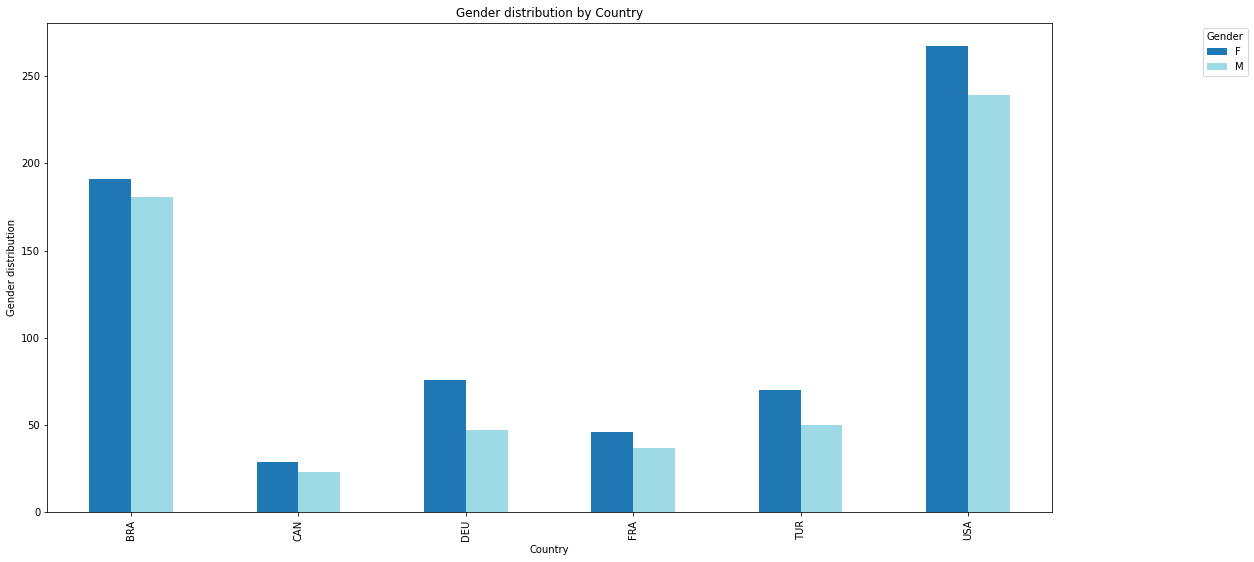

In [623]:
# age distribution by country

# unique users per country
age_counts_per_country = filtered_ages_under_45.groupby(['country', 'gender'])['uid'].nunique().reset_index(name='count')

fig, ax = plt.subplots(figsize=(18, 9))
cmap=plt.get_cmap('tab20')
age_counts_per_country.pivot(index= 'country', columns='gender', values='count').plot(kind = 'bar', ax=ax,cmap=cmap)

ax.set_xlabel('Country')
ax.set_ylabel('Gender distribution')
ax.set_title ('Gender distribution by Country')
ax.legend(title='Gender', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

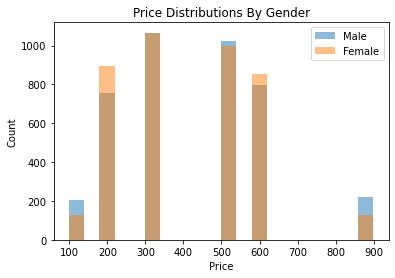

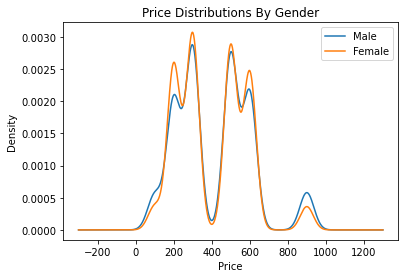

In [624]:
# plotting the perferred price point for each gender

# Resample the data to balance the sample size in each group
male_prices = filtered_ages.loc[filtered_ages['gender'] == 'M', 'price']
female_prices = filtered_ages.loc[filtered_ages['gender'] == 'F', 'price']

# random sample from each set
min_size = min(len(male_prices), len(female_prices))
male_prices = male_prices.sample(min_size, random_state=1)
female_prices = female_prices.sample(min_size, random_state=1)

# plotting the distributions, histogram
plt.hist(male_prices, bins=20, alpha=0.5, label="Male")
plt.hist(female_prices, bins=20, alpha=0.5, label="Female")
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distributions By Gender")
plt.legend()
plt.show()


# plot kde
plt.figure()
male_prices.plot(kind='kde', label="Male")
female_prices.plot(kind='kde', label="Female")
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Price Distributions By Gender")
plt.legend()
plt.show()

<b> Observation </b>
<ul>
<li> There are more females then males </li>
<li> When looking at all the data males generate more on average , but females produce a higher total revenue</li>
<li> Within the apps age based,15-45, females generate more money in total and on average</li>
<li> The gender does play into effect when it comes to revenue generation, it's statistically significant as seen from the t-test </li>
<li> Males are more likely to pay, an average of 9.6056 more than females </li>
<li> Both genders are likely to purchase subscriptions when the price is between $2 and $6, but the ideal price being closer to $3</li>
<li> Young adults account for the most amount of revenue. </li>
 



### Exploring Price & Country


In [625]:
# how many countries are there
uid_combined_data.country.nunique()

6

In [626]:
# how many unique users in each country 
unique_users_region = uid_combined_data.groupby('country').agg({'uid': 'nunique'}).sort_values(by='uid', ascending=False)
unique_users_region.reset_index()

,country,uid
0,USA,539
1,BRA,385
2,TUR,129
3,DEU,126
4,FRA,88
5,CAN,55


Text(0.5, 1.0, 'Unique Player Count by Country')

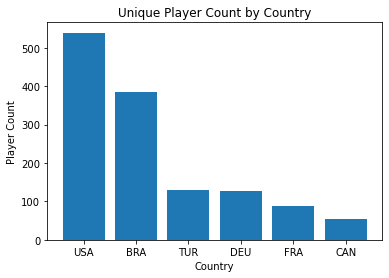

In [627]:
plt.bar(unique_users_region.index, unique_users_region.uid)
plt.xlabel('Country')
plt.ylabel('Player Count')
plt.title('Unique Player Count by Country')

In [628]:
purchase_region = uid_combined_data.groupby('country').agg({'price': ['mean', 'median', 'std', 'min', 'max', 'sum', 'count']})
purchase_region.sort_values(by = ('price', 'sum'), ascending=False).sort_values(by = ('price','mean'), ascending=False)

price                                           
               mean median         std min  max      sum count
country                                                       
TUR      415.417910  499.0  193.876633  99  899   333996   804
BRA      409.838901  499.0  191.504978  99  899  1104106  2694
DEU      409.054645  499.0  178.209847  99  899   374285   915
USA      403.712329  299.0  186.733872  99  899  1473550  3650
FRA      401.757353  299.0  186.396792  99  899   218556   544
CAN      398.248120  299.0  185.868695  99  899   158901   399

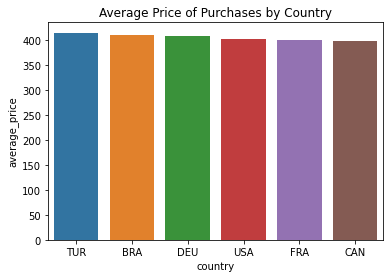

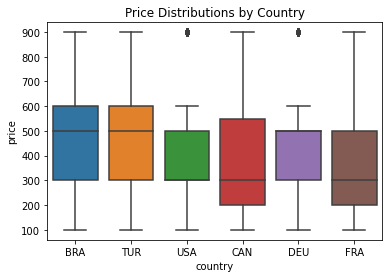

In [629]:
# calculating the average price of purchases per country 
average_prices = uid_combined_data.groupby('country')['price'].mean().reset_index(name='average_price').sort_values(by='average_price', ascending=False)

# plot the average prices 
sns.barplot(x='country', y='average_price', data=average_prices)
plt.title('Average Price of Purchases by Country')
plt.show()

# plot the distributions of prices
sns.boxplot(x='country', y='price', data=uid_combined_data)
plt.title('Price Distributions by Country')
plt.show()

<AxesSubplot:>

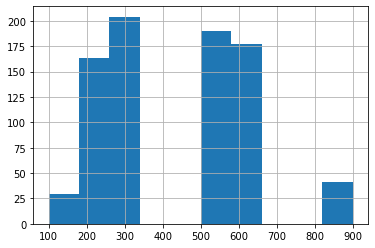

In [630]:
# plotting the distibution of prices in the country with the highest average price (TUR), and the country with the most amount of revenue (USA)
turkey_purchases = uid_combined_data.loc[uid_combined_data['country'] == 'TUR', 'price']
turkey_purchases.hist()

<AxesSubplot:>

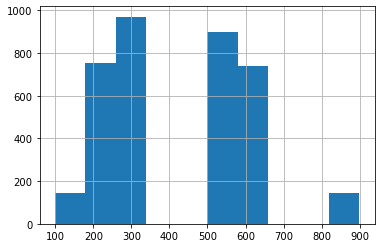

In [631]:
usa_purchases = uid_combined_data.loc[uid_combined_data['country'] == 'USA', 'price']
usa_purchases.hist()

In [632]:
# running an anova test to see if there is a significant difference between the average price of purchases in each country
# null hypothesis: there are no differences between the groups
anova_result = pg.anova(data=uid_combined_data, dv='price', between='country')
anova_result

if anova_result['p-unc'][0] < 0.05:
    print("There is a significant difference between the average price of purchases in each country")
else:
    print("There is no significant difference between the average price of purchases in each country")

There is no significant difference between the average price of purchases in each country


In [633]:
# Perform Tukey's HSD test
posthoc = pg.pairwise_tukey(data=uid_combined_data, dv='price', between='country', effsize='cohen')

print(posthoc.head())


     A    B     mean(A)     mean(B)       diff         se         T   p-tukey  \
0  BRA  CAN  409.838901  398.248120  11.590781  10.080455  1.149827  0.860355   
1  BRA  DEU  409.838901  409.054645   0.784256   7.190507  0.109068  0.999998   
2  BRA  FRA  409.838901  401.757353   8.081548   8.833150  0.914911  0.942841   
3  BRA  TUR  409.838901  415.417910  -5.579009   7.551939 -0.738752  0.977111   
4  BRA  USA  409.838901  403.712329   6.126572   4.773224  1.283529  0.794211   

      cohen  
0  0.060752  
1  0.004167  
2  0.042388  
3 -0.029049  
4  0.032454  


In [634]:
# filtering out those with a cohen effect size of less than 0.2
posthoc_filtered = posthoc[ (posthoc['cohen'] < 0.2) & (posthoc['cohen'] > 0)]
posthoc_filtered.sort_values(by='cohen', ascending=False)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
14,TUR,USA,415.417910,403.712329,11.705582,7.321095,1.598884,0.599305,0.062250
0,BRA,CAN,409.838901,398.248120,11.590781,10.080455,1.149827,0.860355,0.060752
2,BRA,FRA,409.838901,401.757353,8.081548,8.833150,0.914911,0.942841,0.042388
9,DEU,FRA,409.054645,401.757353,7.297292,10.174031,0.717247,0.979920,0.040249
4,BRA,USA,409.838901,403.712329,6.126572,4.773224,1.283529,0.794211,0.032454
11,DEU,USA,409.054645,403.712329,5.342316,6.947664,0.768937,0.972708,0.028868
1,BRA,DEU,409.838901,409.054645,0.784256,7.190507,0.109068,0.999998,0.004167


<b> Observation </b>
<ul>
<li> USA has the highest number of unique users</li>
<li> USA has the most amount of revenue</li>
<li> Turkey generated the highest average per user revenue</li>
<li> The average subscription price purchased for Turkey was $5, where as the USA has a range of purchases subscriptions at a higher frequency</li>
<li> Turkey and Germany (DEU) has on average generated the same amount of revenue, its important to note that the also almost have the same number of users</li> 
<li> There is a purchase price difference between Turkey and USA, and Brazil and Canada</li>
</ul>
 



### Exploring Price & Devices

In [635]:
# exploring unique users 
purchase_devices = uid_combined_data.groupby('device')['uid'].nunique().reset_index(name='count')
purchase_devices.head()

,device,count
0,and,790
1,iOS,532


In [636]:
# exploring devices
purchase_devices = uid_combined_data.groupby('device').agg({'price': ['mean', 'median', 'std', 'min', 'max', 'sum']})
purchase_devices.head()

price                                     
              mean median         std min  max      sum
device                                                 
and     408.111319  299.0  187.415789  99  899  2181355
iOS     404.818082  299.0  188.657954  99  899  1482039

In [637]:
# exploring gender and phones
devices_gender = uid_combined_data.groupby(['gender', 'device']).agg({'uid': 'nunique'}).reset_index()
devices_gender

,gender,device,uid
0,F,and,435
1,F,iOS,277
2,M,and,355
3,M,iOS,255


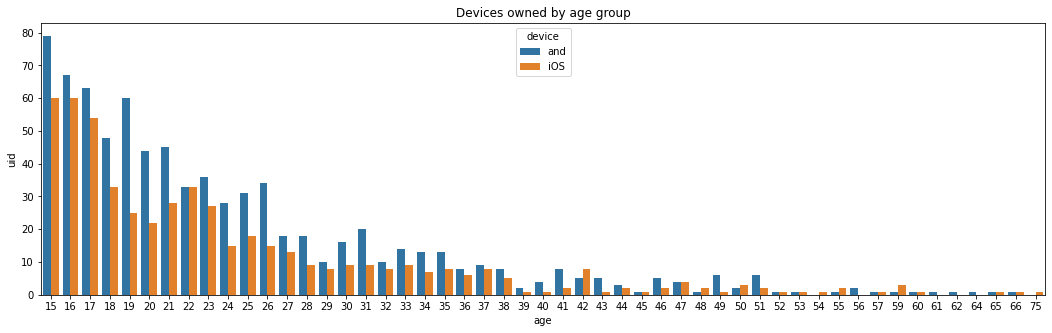

In [638]:
# age group and devices
devices_age = uid_combined_data.groupby(['age', 'device']).agg({'uid': 'nunique'}).reset_index()


plt.figure(figsize=(18, 5))
p = sns.barplot(x='age', y='uid', hue='device', data=devices_age)
plt.title("Devices owned by age group")
plt.show()

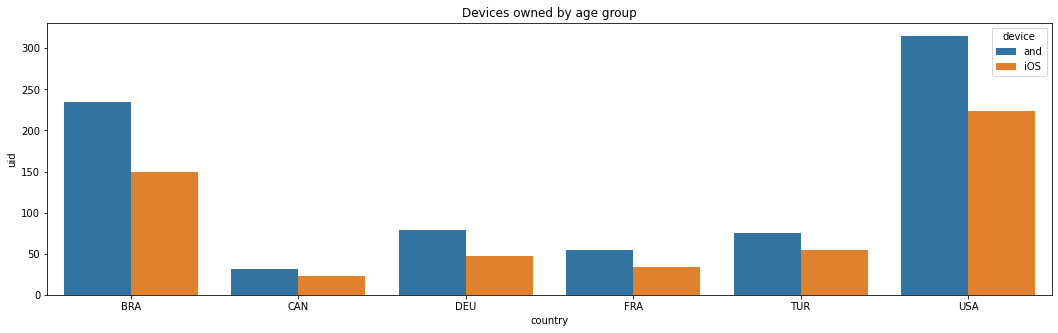

In [639]:
# country and devices
devices_country = uid_combined_data.groupby(['country', 'device']).agg({'uid': 'nunique'}).reset_index()

plt.figure(figsize=(18, 5))
p = sns.barplot(x='country', y='uid', hue='device', data=devices_country)
plt.title("Devices owned by age group")
plt.show()

<b> Observation </b>
<ul>
<li>There are more andriod devices</li>
<li> Android devices generate more revenue</li>
<li> Females own more android and IOS devices then males, and we explored earlier that they generate more revenue</li>
<li> The most amount of devices are owned by the typical user age range  (<45), and that's true across all countries </li>
</ul>
 



### Exploring Purchases Over Time 


In [640]:
uid_combined_data['date'] = pd.to_datetime(uid_combined_data['date']).dt.date
uid_combined_data['reg_date'] = pd.to_datetime(uid_combined_data['reg_date'],format='%Y-%m-%d').dt.date

<AxesSubplot:title={'center':'Average Weekly Purchases'}, xlabel='Week', ylabel='Average Price'>

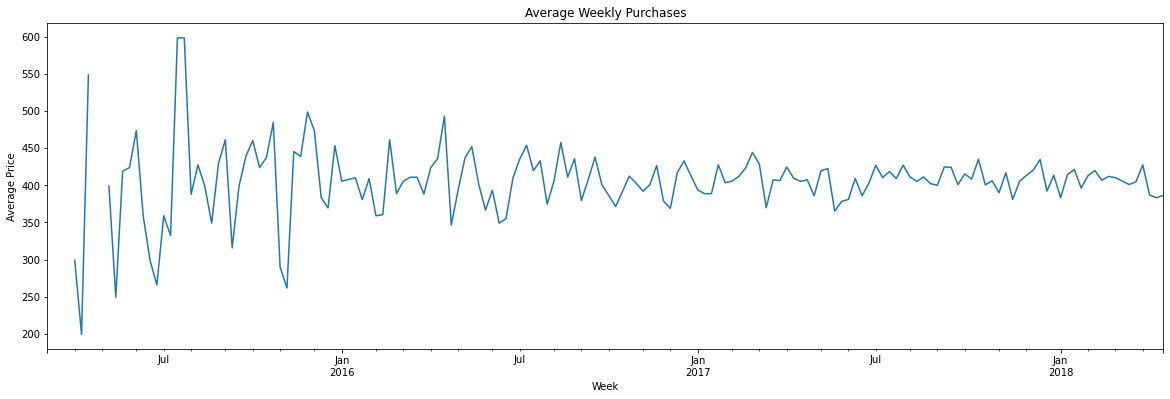

In [673]:
# weekly_data_temp = uid_combined_data.copy()

# setting the date as an index
# weekly_data_temp.index = pd.DatetimeIndex(weekly_data_temp.date)

# creating a frequency of week on the date index
weekly_data = weekly_data_temp.groupby(pd.Grouper(freq='W'))['price'].mean()

# Plot the average weekly purchases
weekly_data.plot(kind='line', figsize=(20, 6), xlabel='Week', ylabel='Average Price', title='Average Weekly Purchases')

In [676]:
# till first purchase 
uid_combined_data['purchase_since_reg'] = ( uid_combined_data['date']  - uid_combined_data['reg_date']).dt.days
uid_combined_data.head()

,date,uid,sku,price,reg_date,device,gender,country,age,age_group,is_female,is_male,purchase_since_reg
0,2017-07-10,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17,"(16, 17]",0,1,14
1,2017-07-15,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17,"(16, 17]",0,1,19
2,2017-11-12,41195147,sku_four_599,599,2017-06-26,and,M,BRA,17,"(16, 17]",0,1,139
3,2017-09-26,91591874,sku_two_299,299,2017-01-05,and,M,TUR,17,"(16, 17]",0,1,264
4,2017-12-01,91591874,sku_four_599,599,2017-01-05,and,M,TUR,17,"(16, 17]",0,1,330


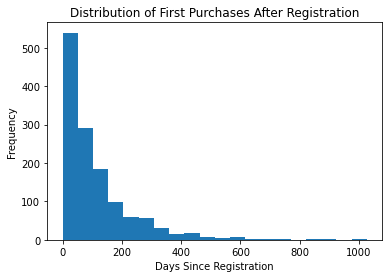

In [722]:
# Group the data by uid and reg_date, and select the first purchase made by each user, since users can make multiple purchases
first_purchases = uid_combined_data.groupby(['uid', 'reg_date']).first()

# Plot the first purchases made by each user
first_purchases['purchase_since_reg'].plot(kind='hist', bins=20)

plt.xlabel('Days Since Registration')
plt.ylabel('Frequency')
plt.title('Distribution of First Purchases After Registration')
plt.show()

In [724]:
first_purchases.purchase_since_reg.describe()

count    1322.000000
mean      110.438729
std       124.880580
min         0.000000
25%        26.250000
50%        70.000000
75%       145.000000
max      1027.000000
Name: purchase_since_reg, dtype: float64

In [732]:
# how many users bought within the first 100 days  - conversion 
print(len(first_purchases)/uid_combined_data.uid.nunique()* 100, 'conversion rate')

100.0 conversion rate


In [747]:
# how many bought mutiple times within the 100 days
users_100 = uid_combined_data[uid_combined_data['purchase_since_reg'] <= 100]
users_100_counts = users_100.groupby('uid')['sku'].count()

multiple_purchase_users = (users_100_counts > 1).sum()
print('{} bought more than one subscription within the first 100 days, thats {}% of the users'.format(multiple_purchase_users, \
                                                                multiple_purchase_users/uid_combined_data.uid.nunique()*100))

567 bought more than one subscription within the first 100 days, thats 42.88956127080182% of the users


<b> Observation </b>
<ul>
<li> The average purchase price is consistently above $3 for subscribing users after Jan 2016</li>
<li> The average time between registering and purchasing a subscription is 110 days, with a minimum of 0 days and a maximum of 1000+ days </li>
<li> The app generate 100% conversion rate within the first 100 days, out of which a 42% of the users bought multiple subscriptions </li>
</ul>